 Import Libraries

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


Set Constants and Paths

In [3]:
# Set image size and other parameters
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 10

# Path to dataset
train_dir = 'dataset/train'
test_dir = 'dataset/test'


Create Image Data Generators

In [4]:
# Data augmentation for training, only rescaling for testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)


 Load Images from Directory

In [5]:
# Class names based on folder structure
class_names = ['freshapples', 'freshbanana', 'freshoranges',
               'rottenapples', 'rottenbanana', 'rottenoranges']

# Training data loader
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    classes=class_names,
    class_mode='binary',
    shuffle=True
)

# Testing data loader
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    classes=class_names,
    class_mode='binary',
    shuffle=False
)


Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


Convert to Binary Classes (Fresh = 0, Rotten = 1)

In [6]:
# Map all fresh* folders to class 0, rotten* to class 1
binary_map = {name: 0 if 'fresh' in name else 1 for name in class_names}

# Apply binary labels to generators
train_generator.classes = np.array([binary_map[path.split(os.sep)[0]] for path in train_generator.filenames])
test_generator.classes = np.array([binary_map[path.split(os.sep)[0]] for path in test_generator.filenames])

Build the CNN Model

In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(*IMAGE_SIZE, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])


c:\Users\riyad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile the Model

In [8]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [9]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)


c:\Users\riyad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 219s 636ms/step - accuracy: 0.7144 - loss: 0.5522 - val_accuracy: 0.9181 - val_loss: 0.2012
Epoch 2/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 225s 656ms/step - accuracy: 0.9146 - loss: 0.2267 - val_accuracy: 0.9144 - val_loss: 0.2328
Epoch 3/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 202s 591ms/step - accuracy: 0.9257 - loss: 0.1974 - val_accuracy: 0.9188 - val_loss: 0.2195
Epoch 4/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 177s 518ms/step - accuracy: 0.9276 - loss: 0.1993 - val_accuracy: 0.9351 - val_loss: 0.1693
Epoch 5/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 192s 563ms/step - accuracy: 0.9321 - loss: 0.1714 - val_accuracy: 0.9626 - val_loss: 0.1145
Epoch 6/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 233s 684ms/step - accuracy: 0.9422 - loss: 0.1428 - val_accuracy: 0.9463 - val_loss: 0.1304
Epoch 7/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 260s 761ms/step - accuracy: 0.9453 - loss: 0.1349 - val_accuracy: 0.9607 - val_loss: 0.1044
Epoch 8/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 245s 720ms/step - accuracy: 0.9545 -

 Evaluate the Model

In [10]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 196ms/step - accuracy: 0.9773 - loss: 0.0714
Test Accuracy: 97.70%


Classification Report & Confusion Matrix

In [11]:
# Predict class probabilities
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int)

# Generate report
print("Classification Report:\n")
print(classification_report(test_generator.classes, y_pred, target_names=['Fresh', 'Rotten']))


85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 185ms/step
Classification Report:

              precision    recall  f1-score   support

       Fresh       0.97      0.97      0.97      1164
      Rotten       0.98      0.98      0.98      1534

    accuracy                           0.98      2698
   macro avg       0.98      0.98      0.98      2698
weighted avg       0.98      0.98      0.98      2698



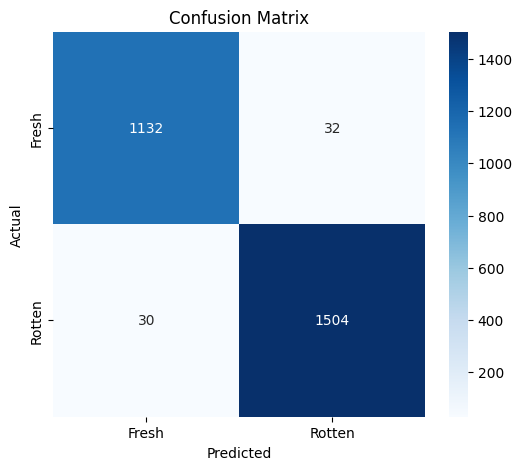

In [12]:
# Plot Confusion Matrix

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fresh', 'Rotten'], yticklabels=['Fresh', 'Rotten'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


 Plot Training History (Accuracy & Loss)

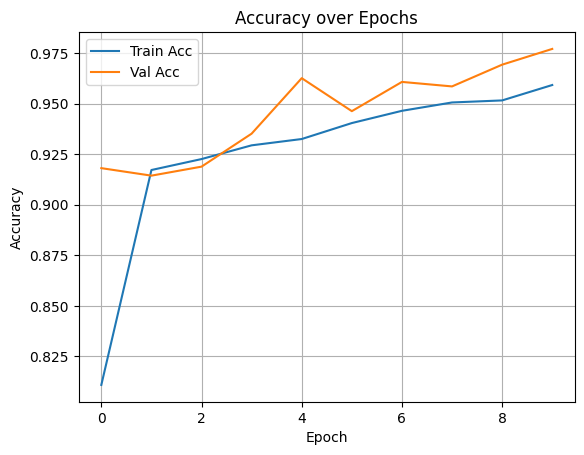

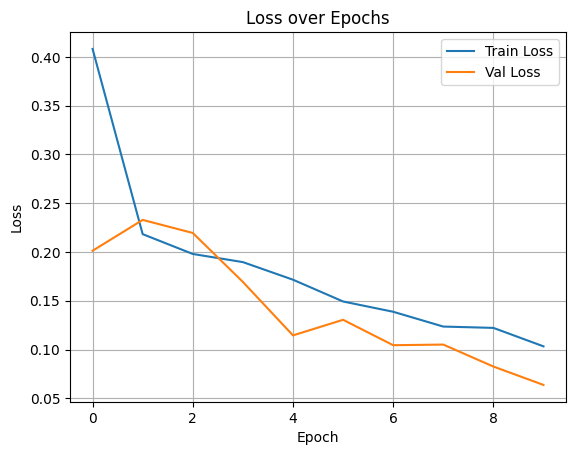

In [13]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
model.save("fruit_classifier_model.h5")
